In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from os.path import join
from tqdm import tqdm
from matplotlib.colors import LogNorm

import strawb
from strawb.tools import wavelength_to_rgb

import seaborn as sns


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../no_git/style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]


# Histogram helpers

-0.0565071343132979
-2.902440654465501
2.4456223364245453


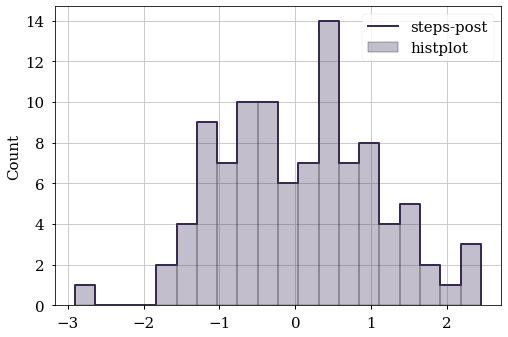

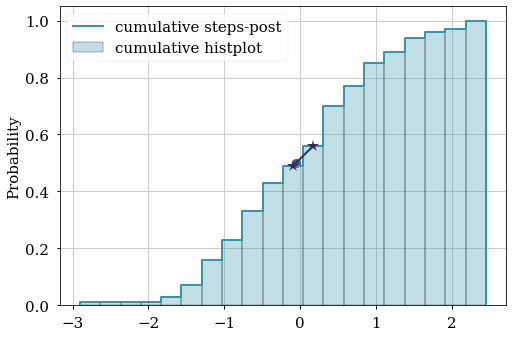

In [4]:
def interpolate_quantile_value(
    q, xedges, yvals, offset=0, offset_type="underflow", verbose=False
):
    r"""Interpolate quantile values from a histogram.

    Parameters:
    -----------
    q: quantile, float between 0 and 1
    xedges: bin edges of the histogram with length n+1
    yvals: heights of the bins with length n
    offset: account for a low offset/underflow bin not in yvals
    offset_type: 'underflow', 'overflow'
    verbose: returns also the coordinates used for interpolation

    Returns:
    --------
    Quantile value based on interpolated histogram values,
    verbose=True: x and y coordinates of 2 points used for interpolation
    """
    cumulative_yvals = np.cumsum(yvals).astype(float)
    cumulative_yvals /= cumulative_yvals[-1]
    if offset_type == "underflow":
        cumulative_yvals += offset
        cumulative_yvals /= np.max(cumulative_yvals)
    elif offset_type == "overflow":
        cumulative_yvals /= offset

    mids = (xedges[:-1] + xedges[1:]) * 0.5
    mask_s = cumulative_yvals <= q
    mask_l = cumulative_yvals > q
    try:
        x1 = np.atleast_1d(mids[mask_s])[-1]
        x2 = np.atleast_1d(mids[mask_l])[0]
        y1 = np.atleast_1d(cumulative_yvals[mask_s])[-1]
        y2 = np.atleast_1d(cumulative_yvals[mask_l])[0]
    except:
        # this means the quantile is either in the lowest or the highest bin
        if np.count_nonzero(mask_s) == 0:
            if verbose:
                print("Quantile is in lowest bin")
            return xedges[0]
        elif np.count_nonzero(mask_l) == 0:
            if verbose:
                print("Quantile is in highest bin")
            return xedges[1:][yvals > 0][-1]
        else:
            if verbose:
                print("Something weird happened??? Please check")
            return None
    if verbose:
        # we want to have the x-value to the quantile,
        # so we need to switch x and y here
        return np.interp(q, [y1, y2], [x1, x2]), [y1, y2], [x1, x2]
    else:
        return np.interp(q, [y1, y2], [x1, x2])

def histplot_from_nphist(h, ed, nfig=1, **kwargs):
    r"""Make a histogram plot from np.histogram values 'h' and edges 'ed'."""
    plt.figure(nfig)
    plt.plot(
        np.concatenate([[ed[0]], ed, [ed[-1]]]),
        np.concatenate([[0], h, [h[-1], 0]]),
        ds="steps-post",
        **kwargs
    )

## test histogram helpers
bins = 20  # np.linspace(-3, 3, 25)
rand = np.random.normal(size=100)
h, ed = np.histogram(rand, bins=bins)
histplot_from_nphist(h, ed, label="steps-post")
sns.histplot(rand, bins=ed, label="histplot", alpha=0.3)
plt.legend()

ch = np.cumsum(h) / np.sum(h)
histplot_from_nphist(
    ch,
    ed,
    nfig=2,
    label="cumulative steps-post",
    color=colorlist[2],
)
sns.histplot(
    rand,
    bins=ed,
    label="cumulative histplot",
    alpha=0.3,
    cumulative=True,
    color=colorlist[2],
    stat="probability",
)

q = 0.5
val, yy, xx = interpolate_quantile_value(q, ed, h, verbose=True)
print(val)
plt.plot(xx, yy, marker="*", ms=12)
plt.scatter(val, q, s=80)
plt.legend()

val = interpolate_quantile_value(q, ed, h, offset=3, offset_type="underflow")
print(val)

val = interpolate_quantile_value(q, ed, h, offset=3, offset_type="overflow")
print(val)


# Setup

In [5]:
# load DB
db = strawb.SyncDBHandler(file_name="Default")  # loads the db


In [6]:
### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR
print(db.dataframe.measurement_type.unique())


['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
[nan 'counts' 'rate_scan' 'basic']


## select time range

In [10]:
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

#timestamp = np.datetime64("2021-09-01T00:00:00")
timestamp = np.datetime64("2021-07-12T00:00:00")
mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
mask &= db.dataframe.dateFrom < pd.Timestamp(
    np.datetime64(timestamp, "h"), tz="UTC"
) + np.timedelta64(1, "D")


/tmp/ipykernel_13253/2111142421.py:6: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
/tmp/ipykernel_13253/2111142421.py:7: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom < pd.Timestamp(


In [11]:
db.dataframe[mask].iloc[-1].dateFrom

Timestamp('2021-07-12 23:00:00+0000', tz='UTC')

In [12]:
### see which files are synced
np.count_nonzero(db.dataframe[mask].synced), len(db.dataframe[mask])


(0, 27)

In [13]:
db.dataframe["file_ok"].head()


fullPath
/data/straw_b/raw_module_data/oncmjb016/2020_10/ONCMJB016_20201001T000000.000Z.txt                              None
/data/straw_b/raw_module_data/tumlidar001/2020_10/TUMLIDAR001_20201001T000000.000Z.txt                          None
/data/straw_b/raw_module_data/tumlidar002/2020_10/TUMLIDAR002_20201001T000000.000Z.txt                          None
/data/straw_b/raw_module_data/tumminispectrometer001/2020_10/TUMMINISPECTROMETER001_20201001T000000.000Z.txt    None
/data/straw_b/raw_module_data/tummuontracker001/2020_10/TUMMUONTRACKER001_20201001T000000.000Z.txt              None
Name: file_ok, dtype: object

## download missing files

In [14]:
# check if files will be downloaded
if not db.dataframe.synced[mask].all():
    print("Files will be downloaded")
else:
    print("No files will be downloaded")


Files will be downloaded


In [15]:
### this will download the selected files
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        # save_db=True
    )
    db.save_db()


  In total: 27 files; skips synced: 0; size to download: 671.52 MB, from deviceCode: ['TUMPMTSPECTROMETER001']

-> Download the files from the ONC server
100%|██████████| 27/27 [07:02<00:00, 15.64s/file, i=TUMPMTSPECTROMETER001_20210712T230000.000Z-SDAQ-PMTSPEC.hdf5]
Downloaded - Directory: /data/straw_b/raw_module_data; Files: 27; Size: 704.1 MB; Time: 7 minutes; Speed: 1.7 MB/s

-> Update hdf5 attributes
100%|██████████| 27/27 [00:00<00:00, 121.79files/s, i=1]

-> Add to db


In [16]:
# mask by device
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

# and add mask by 'measurement_type'
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
mask &= db.dataframe["synced"]


# Rate counting

## testing

In [ ]:
# single test
pmtspec = strawb.sensors.PMTSpec(
    "/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T000000.000Z-SDAQ-PMTSPEC.hdf5"
)


In [ ]:
# visualize the delta t counting intervals for one file
ax = sns.histplot(np.log10(pmtspec.trb_rates.rate_delta_time), bins=np.linspace(-4.1, 1))
ax.set_yscale("log")
ax.set_xlabel("log10(rate_delta_time)")
ax.set_title("20210901T000000")

## load data

In [ ]:
testing = True
rate_bins = np.arange(-1, 9, step=0.1)
time_bins = np.arange(-5, 6.1, step=0.1)


In [ ]:
# identifier = "20210901-20210930"
# good_trb_series_sep = pd.read_pickle(
#     f"/data/straw_b/processed_data/pmtspectrometer001/dataframes/{identifier}_good_trb_series.pickle"
# )
# 
# identifier = "20211001-20211010"
# good_trb_series_oct = pd.read_pickle(
#     f"/data/straw_b/processed_data/pmtspectrometer001/dataframes/{identifier}_good_trb_series.pickle"
# )

identifier = "20210901-20211010"
good_trb_series_oct = pd.read_pickle(
    f"/data/straw_b/processed_data/pmtspectrometer001/dataframes/{identifier}_good_trb_series.pickle"
)


## read data

In [ ]:
# select file with the right data
mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
mask &= db.dataframe.dataProductCode == "PMTSD"
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
# only synced data
mask &= db.dataframe.synced
if testing:
    # for testing, we can use a shorter time window of one day
    timestamp1 = "20211001" #"20210924"
    timestamp2 = "20211010" #"20210925"
    mask &= db.dataframe.dateFrom >= pd.Timestamp(timestamp1, tz="UTC")
    mask &= db.dataframe.dateFrom < pd.Timestamp(timestamp2, tz="UTC")
    identifier = "-".join([timestamp1, timestamp2])
else:
    identifier = "20210901-20211010"

print("identifier will be", identifier)
print(np.count_nonzero(mask), "files will be read.")


In [ ]:
# load PMTSpec
good_trb_series = []

for i, row in tqdm(db.dataframe[mask].iterrows()):
    # skip files that we know are bad
    if row.file_ok == "corrupt" or row.file_ok == "empty":
        continue
    try:
        # get the PMT data and its meta data (channel no. etc)
        pmt_specs_timeseries = strawb.sensors.PMTSpec(row.filename)
        meta = pmt_specs_timeseries.pmt_meta_data.channel_meta_array
        # select the channel with no wavelength filter
        filter_ind = meta[meta["wavelength"] == 0]["index"][0]
        selection = pmt_specs_timeseries.trb_rates.rate[filter_ind]
        # --> as long as all this works, we don't expect any further file-reading errors
    except KeyError:
        # corrupt file
        print("Corrupt file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "corrupt"
        continue
    except OSError:
        # also corrupt file
        print("Corrupt file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "corrupt"
        continue
    except TypeError as e:
        # empty file
        print("Empty file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "empty"
        continue
    # loop over all wavelength channels
    for mm in meta:
        # select one wavelength channel
        selection = pmt_specs_timeseries.trb_rates.rate[mm["index"]]
        # aggregate bins into something roughly representing 30 ms (=30 bins)
        # this is thus an average rate over multiple time bins
        # loop over how many bins will be aggregated
        for stepsize in [1, 30]:
            indx = np.arange(len(selection), step=stepsize)

            # weight the sum by the size of the time bins
            agg_delta_time = np.add.reduceat(
                pmt_specs_timeseries.trb_rates.rate_delta_time, indx
            )
            agg_rates = (
                np.add.reduceat(
                    selection * pmt_specs_timeseries.trb_rates.rate_delta_time, indx
                )
                / agg_delta_time
            )

            # build a histogram of the rate series
            # mask rate counts with zero that mess up the log()
            mask = agg_rates > 0
            # check that the bin range is large enough
            assert rate_bins[-1] > np.max(
                np.log10(agg_rates[mask])
            ), f"rate binning too small, out of range: {np.max(np.log10(agg_rates[mask]))}"
            assert rate_bins[1] < np.min(
                np.log10(agg_rates[mask])
            ), f"rate binning too small, out of range: {np.min(np.log10(agg_rates[mask]))}"

            h, ed = np.histogram(np.log10(agg_rates[mask]), bins=rate_bins)
            # ... and a histogram weighted with the size of the time intervals
            hw, _ = np.histogram(
                np.log10(agg_rates[mask]),
                bins=rate_bins,
                weights=agg_delta_time[mask],
            )
            # histogram of the time intervals themselves
            # first, check that the binning is suitable
            assert time_bins[-1] > np.max(
                np.log10(pmt_specs_timeseries.trb_rates.rate_delta_time)
            ), f"time binning too small, out of range {np.max(np.log10(pmt_specs_timeseries.trb_rates.rate_delta_time))}"
            assert time_bins[1] < np.min(
                np.log10(pmt_specs_timeseries.trb_rates.rate_delta_time)
            ), f"time binning too small, out of range {np.min(np.log10(pmt_specs_timeseries.trb_rates.rate_delta_time))}"
            assert time_bins[-1] > np.max(
                np.log10(agg_delta_time)
            ), f"time binning too small, out of range {np.max(np.log10(agg_delta_time))}"
            assert time_bins[1] < np.min(
                np.log10(agg_delta_time)
            ), f"time binning too small, out of range {np.min(np.log10(agg_delta_time))}"
            # raw intervals:
            ht, ted = np.histogram(
                np.log10(pmt_specs_timeseries.trb_rates.rate_delta_time),
                bins=time_bins,
            )
            # aggregated intervals:
            hta, _ = np.histogram(
                np.log10(agg_delta_time),
                bins=time_bins,
            )
            # we want to leave first bin as underflow for zero rate counts
            # -> check that the first bin for underflow is zero
            assert h[0] == 0, "First bin not free for underflow"
            assert hw[0] == 0, "First bin not free for underflow"

            # add zero counts as first "underflow" bin
            # total zero counts
            h[0] = np.count_nonzero(~mask)
            # zero counts weighted with time interval
            hw[0] = np.sum(agg_delta_time[~mask])

            ## percentiles of rate per hour
            quantiles = [0.1, 0.5, 0.9, 0.99]
            tmp = {
                "rate_hist": h,
                "weighted_rate_hist": hw,
                "zero_counts": h[0],
                "weighted_zero_counts": hw[0],
                "delta_time_hist": ht,
                "delta_time_hist_agg": hta,
                "timestamp": pd.Timestamp(row.dateFrom),
                "filter": mm["wavelength"],
                "agg_stepsize": stepsize,
            }
            for q in quantiles:
                tmp[f"q_{int(q*100)}"] = interpolate_quantile_value(q, rate_bins, h)
                tmp[f"q_{int(q*100)}_weighted"] = interpolate_quantile_value(
                    q, rate_bins, hw
                )

            good_trb_series.append(tmp)
    db.dataframe.loc[i, "file_ok"] = "ok"
good_trb_series = pd.DataFrame(good_trb_series)


### save processed data base

In [ ]:
# save our marking of unreadable files, so we can skip them next time
db.save_db()
path = "/data/straw_b/processed_data/pmtspectrometer001/dataframes/"
good_trb_series.to_pickle(path + f"{identifier}_good_trb_series.pickle")


### check if broken files show in file sizes


In [ ]:
db.dataframe[
    (db.dataframe.file_ok == "corrupt") | (db.dataframe.file_ok == "empty")
].fileSize #[:3]


## rate plots

### plot quantiles

In [ ]:
fil = 0
f, axes = plt.subplots()
#mask = good_trb_series.timestamp <= pd.Timestamp(np.datetime64("2021-09-15T12:00:00"), tz="utc")
#mask &= good_trb_series.timestamp >= pd.Timestamp(np.datetime64("2021-09-10T12:00:00"), tz="utc")
mask = good_trb_series.stepsize == 30
mask &= good_trb_series["filter"] == fil
kws = dict(marker="o", ms=0, lw=1)
axes.plot(
    good_trb_series.timestamp[mask], good_trb_series.q_90[mask], label="90%", **kws
)
axes.plot(
    good_trb_series.timestamp[mask], good_trb_series.q_50[mask], label="50%", **kws
)
axes.plot(
    good_trb_series.timestamp[mask], good_trb_series.q_10[mask], label="10%", **kws
)
axes.set_ylabel("log10(rate/Hz)")
axes.set_title(f"Hourly rate quantiles, filter: {filters[0]} nm")
axes.set_xlabel("Timestamp")
axes.legend()
plt.xticks(rotation=90)
f.tight_layout()


In [ ]:
filters = good_trb_series["filter"].unique()
f, axes = plt.subplots(figsize=(8, 24), sharex=True, nrows=len(filters))
for i, fil in enumerate(filters):
    #mask = good_trb_series.timestamp <= pd.Timestamp(np.datetime64("2021-09-15T12:00:00"), tz="utc")
    #mask &= good_trb_series.timestamp >= pd.Timestamp(np.datetime64("2021-09-10T12:00:00"), tz="utc")
    mask = good_trb_series.stepsize == 30
    mask &= good_trb_series["filter"] == fil
    kws = dict(marker="o", ms=0, lw=1)
    axes[i].plot(
        good_trb_series.timestamp[mask], good_trb_series.q_90[mask], label="90%", **kws
    )
    axes[i].plot(
        good_trb_series.timestamp[mask], good_trb_series.q_50[mask], label="50%", **kws
    )
    axes[i].plot(
        good_trb_series.timestamp[mask], good_trb_series.q_10[mask], label="10%", **kws
    )
    axes[i].set_title(f"filter: {fil} nm")
    axes[i].set_ylabel("log10(rate/Hz)")
axes[0].set_title(f"Hourly rate quantiles, filter: {filters[0]} nm")
axes[-1].set_xlabel("Timestamp")
axes[-1].legend()
plt.xticks(rotation=90)
f.tight_layout()
#plt.savefig("../no_git/plot_dump/rate_quantiles_per_hour.png", bbox_inches="tight")


### plot rate hist and cumulative + sum

In [ ]:
weird_index = np.where(np.isclose(rate_bins, 4))[0][0]

weird_indices = np.arange(weird_index -5, weird_index + 5)
weirdo_data = []
for _, trb in good_trb_series.iterrows():
    b = np.any(trb["weighted_rate_hist"][weird_indices] > 5E3)
    if b:
        weirdo_data.append(trb["timestamp"])
weirdo_data = np.array(weirdo_data)
print(np.unique(weirdo_data))

In [ ]:
## total rates, cumulative rates, per hour
# 'NO FILTER' selection

plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))
plt.figure(5, figsize=(10, 6))
plt.figure(6, figsize=(10, 6))

timestamp = np.datetime64("2021-10-10T23:00:00")
mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")
# no wavelength filter
mask &= good_trb_series["filter"] == 0
# averaged rate over 30 bins
mask &= good_trb_series["agg_stepsize"] == 30
# mask out failures
mask &= good_trb_series["q_50_weighted"] > 2
#mask &= good_trb_series["q_50_weighted"] < 4.5
### CHECK THE WEIRD INDICES??
m = good_trb_series["timestamp"] != weirdo_data[0]
for w in weirdo_data[1:]:
    m &= good_trb_series["timestamp"] != w
mask &= ~m

for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], rate_bins, nfig=1, **kws)
    ## cumulative weighted rate hist
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    kws = dict(alpha=0.07, color=colorlist[0])
    histplot_from_nphist(cs[::-1], rate_bins, nfig=2, **kws)
    ## rate hist
    histplot_from_nphist(trb.rate_hist, rate_bins, nfig=3, **kws)
    ## weighted rate hist
    histplot_from_nphist(trb.weighted_rate_hist, rate_bins, nfig=4, **kws)
    ## delta time hist
    histplot_from_nphist(trb.delta_time_hist, time_bins, nfig=5, **kws)
    ## delta time hist aggregated
    histplot_from_nphist(
        trb.delta_time_hist_agg, time_bins, nfig=6, **kws
    )
# summed up (cumulative) histograms over whole time range
# raw
rate_sum = good_trb_series[mask].rate_hist.sum()
cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
histplot_from_nphist(cs[::-1], rate_bins, nfig=1, label="average", color="tomato", lw=3)
histplot_from_nphist(rate_sum, rate_bins, nfig=3, label="sum", color="tomato", lw=3)
# weighted
weighted_rate_sum = good_trb_series[mask].weighted_rate_hist.sum()
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]
histplot_from_nphist(
    wcs[::-1], rate_bins, nfig=2, label="average", color="tomato", lw=3
)
histplot_from_nphist(
    weighted_rate_sum, rate_bins, nfig=4, label="sum", color="tomato", lw=3
)
# delta time
delta_time_sum = good_trb_series[mask].delta_time_hist.sum()
histplot_from_nphist(
    delta_time_sum, time_bins, nfig=5, label="sum", color="tomato", lw=3, ls="--"
)
# delta time aggregated
delta_time_sum = good_trb_series[mask].delta_time_hist_agg.sum()
histplot_from_nphist(
    delta_time_sum, time_bins, nfig=6, label="sum agg.", color="seagreen", lw=3, ls="--"
)

quantiles = [0.99, 0.9, 0.5, 0.1]
for i, q in enumerate(quantiles):
    thresh = interpolate_quantile_value(q, rate_bins, rate_sum)
    if thresh is not None:
        plt.figure(1)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(3)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )

    thresh = interpolate_quantile_value(
        q,
        rate_bins,
        weighted_rate_sum,
    )
    if thresh is not None:
        plt.figure(2)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(4)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig(
        "../no_git/plot_dump/no_filter_cumulative_rate.png", bbox_inches="tight"
    )

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig(
        "../no_git/plot_dump/no_filter_weighted_cumulative_rate.png",
        bbox_inches="tight",
    )

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_weighted_rate.png", bbox_inches="tight")

plt.figure(5)
plt.ylabel("# hist")
plt.xlabel("log(time interval/sec)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_delta_t.png", bbox_inches="tight")

plt.figure(6)
plt.ylabel("# aggregated hist")
plt.xlabel("log(time interval/sec)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_delta_t_aggregated.png", bbox_inches="tight")


In [ ]:
## total rates, cumulative rates, per hour
# 'NO FILTER' selection

plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))
plt.figure(5, figsize=(10, 6))
plt.figure(6, figsize=(10, 6))

timestamp = np.datetime64("2021-10-10T23:00:00")
mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")
# no wavelength filter
mask &= good_trb_series["filter"] == 0
# averaged rate over 30 bins
mask &= good_trb_series["agg_stepsize"] == 30
# mask out failures
mask &= good_trb_series["q_50_weighted"] > 2
#mask &= good_trb_series["q_50_weighted"] < 4.5
for w in weirdo_data:
    mask &= good_trb_series["timestamp"] != w

for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], rate_bins, nfig=1, **kws)
    ## cumulative weighted rate hist
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    kws = dict(alpha=0.07, color=colorlist[0])
    histplot_from_nphist(cs[::-1], rate_bins, nfig=2, **kws)
    ## rate hist
    histplot_from_nphist(trb.rate_hist, rate_bins, nfig=3, **kws)
    ## weighted rate hist
    histplot_from_nphist(trb.weighted_rate_hist, rate_bins, nfig=4, **kws)
    ## delta time hist
    histplot_from_nphist(trb.delta_time_hist, time_bins, nfig=5, **kws)
    ## delta time hist aggregated
    histplot_from_nphist(
        trb.delta_time_hist_agg, time_bins, nfig=6, **kws
    )
# summed up (cumulative) histograms over whole time range
# raw
rate_sum = good_trb_series[mask].rate_hist.sum()
cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
histplot_from_nphist(cs[::-1], rate_bins, nfig=1, label="average", color="tomato", lw=3)
histplot_from_nphist(rate_sum, rate_bins, nfig=3, label="sum", color="tomato", lw=3)
# weighted
weighted_rate_sum = good_trb_series[mask].weighted_rate_hist.sum()
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]
histplot_from_nphist(
    wcs[::-1], rate_bins, nfig=2, label="average", color="tomato", lw=3
)
histplot_from_nphist(
    weighted_rate_sum, rate_bins, nfig=4, label="sum", color="tomato", lw=3
)
# delta time
delta_time_sum = good_trb_series[mask].delta_time_hist.sum()
histplot_from_nphist(
    delta_time_sum, time_bins, nfig=5, label="sum", color="tomato", lw=3, ls="--"
)
# delta time aggregated
delta_time_sum = good_trb_series[mask].delta_time_hist_agg.sum()
histplot_from_nphist(
    delta_time_sum, time_bins, nfig=6, label="sum agg.", color="seagreen", lw=3, ls="--"
)

quantiles = [0.99, 0.9, 0.5, 0.1]
for i, q in enumerate(quantiles):
    thresh = interpolate_quantile_value(q, rate_bins, rate_sum)
    if thresh is not None:
        plt.figure(1)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(3)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )

    thresh = interpolate_quantile_value(
        q,
        rate_bins,
        weighted_rate_sum,
    )
    if thresh is not None:
        plt.figure(2)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(4)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig(
        "../no_git/plot_dump/no_filter_cumulative_rate.png", bbox_inches="tight"
    )

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig(
        "../no_git/plot_dump/no_filter_weighted_cumulative_rate.png",
        bbox_inches="tight",
    )

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_weighted_rate.png", bbox_inches="tight")

plt.figure(5)
plt.ylabel("# hist")
plt.xlabel("log(time interval/sec)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_delta_t.png", bbox_inches="tight")

plt.figure(6)
plt.ylabel("# aggregated hist")
plt.xlabel("log(time interval/sec)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_delta_t_aggregated.png", bbox_inches="tight")


In [ ]:
## total rates, cumulative rates, per hour
# 'NO FILTER' selection

plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))
plt.figure(5, figsize=(10, 6))
plt.figure(6, figsize=(10, 6))

timestamp = np.datetime64("2021-09-30T23:00:00")
mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")
mask &= good_trb_series.timestamp >= pd.Timestamp("2021-09-24 18:00:00", tz="utc")
mask &= good_trb_series.timestamp <= pd.Timestamp("2021-09-25 04:00:00", tz="utc")
mask &= good_trb_series["filter"] == 0
mask &= good_trb_series["agg_stepsize"] == 30

for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], rate_bins, nfig=1, **kws)
    ## cumulative weighted rate hist
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    if trb.timestamp == pd.Timestamp("2021-09-24 21:00:00", tz="utc"):
        kws = dict(alpha=1, color="cyan", label="before crash")
    elif trb.timestamp == pd.Timestamp("2021-09-24 22:00:00", tz="utc"):
        kws = dict(alpha=1, color="magenta", label="after crash")
    else:
        kws = dict(alpha=1, label=trb.timestamp)#, color=colorlist[0])
    histplot_from_nphist(cs[::-1], rate_bins, nfig=2, **kws)
    ## rate hist
    histplot_from_nphist(trb.rate_hist, rate_bins, nfig=3, **kws)
    ## weighted rate hist
    histplot_from_nphist(trb.weighted_rate_hist, rate_bins, nfig=4, **kws)
    ## delta time hist
    histplot_from_nphist(trb.delta_time_hist, time_bins, nfig=5, **kws)
    ## delta time hist aggregated
    histplot_from_nphist(
        trb.delta_time_hist_agg, time_bins, nfig=6, **kws
    )
# summed up (cumulative) histograms over whole time range
# raw
rate_sum = good_trb_series[mask].rate_hist.sum()
cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
histplot_from_nphist(cs[::-1], rate_bins, nfig=1, label="average", color="tomato", lw=3)
histplot_from_nphist(rate_sum, rate_bins, nfig=3, label="sum", color="tomato", lw=3)
# weighted
weighted_rate_sum = good_trb_series[mask].weighted_rate_hist.sum()
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]
histplot_from_nphist(
    wcs[::-1], rate_bins, nfig=2, label="average", color="tomato", lw=3
)
histplot_from_nphist(
    weighted_rate_sum, rate_bins, nfig=4, label="sum", color="tomato", lw=3
)
# delta time
delta_time_sum = good_trb_series[mask].delta_time_hist.sum()
histplot_from_nphist(
    delta_time_sum, time_bins, nfig=5, label="sum", color="tomato", lw=3, ls="--"
)
# delta time aggregated
delta_time_sum = good_trb_series[mask].delta_time_hist_agg.sum()
histplot_from_nphist(
    delta_time_sum, time_bins, nfig=6, label="sum agg.", color="seagreen", lw=3, ls="--"
)

#quantiles = [0.99, 0.9, 0.5, 0.1]
#for i, q in enumerate(quantiles):
#    thresh = interpolate_quantile_value(q, rate_bins, rate_sum)
#    if thresh is not None:
#        plt.figure(1)
#        plt.axvline(
#            thresh,
#            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
#            ls="--",
#            color=colorlist[i % len(colorlist)],
#        )
#        plt.figure(3)
#        plt.axvline(
#            thresh,
#            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
#            ls="--",
#            color=colorlist[i % len(colorlist)],
#        )
#
#    thresh = interpolate_quantile_value(
#        q,
#        rate_bins,
#        weighted_rate_sum,
#    )
#    if thresh is not None:
#        plt.figure(2)
#        plt.axvline(
#            thresh,
#            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
#            ls="--",
#            color=colorlist[i % len(colorlist)],
#        )
#        plt.figure(4)
#        plt.axvline(
#            thresh,
#            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
#            ls="--",
#            color=colorlist[i % len(colorlist)],
#        )


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig(
        "../no_git/plot_dump/no_filter_cumulative_rate.png", bbox_inches="tight"
    )

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig(
        "../no_git/plot_dump/no_filter_weighted_cumulative_rate.png",
        bbox_inches="tight",
    )

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_weighted_rate.png", bbox_inches="tight")

plt.figure(5)
plt.ylabel("# hist")
plt.xlabel("log(time interval/sec)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_delta_t.png", bbox_inches="tight")

plt.figure(6)
plt.ylabel("# aggregated hist")
plt.xlabel("log(time interval/sec)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
if not testing:
    plt.savefig("../no_git/plot_dump/no_filter_delta_t_aggregated.png", bbox_inches="tight")


### same plot, different wavelength filter

In [ ]:
## total rates, cumulative rates, per hour
# NO FILTER selection
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))

timestamp = np.datetime64("2021-09-30T23:00:00")
for wavelen in good_trb_series["filter"].unique():
    mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")
    mask &= good_trb_series["filter"] == wavelen
    kws = dict(alpha=0.05, color=colorlist[0])
    #for _, trb in good_trb_series[mask].iterrows():
    #    ## cumulative rate hist
    #    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    #    cs /= cs[-1]
    #    histplot_from_nphist(cs[::-1], rate_bins, nfig=1, **kws)
    #    ## cumulative weighted rate hist
    #    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    #    cs /= cs[-1]
    #    histplot_from_nphist(cs[::-1], rate_bins, nfig=2, **kws)
    #    ## rate hist
    #    histplot_from_nphist(trb.rate_hist, rate_bins, nfig=3, **kws)
    #    ## weighted rate hist
    #    histplot_from_nphist(trb.weighted_rate_hist, rate_bins, nfig=4, **kws)

    rate_sum = good_trb_series[mask].rate_hist.sum()
    cs = np.cumsum(rate_sum[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(
        cs[::-1], rate_bins, nfig=1, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen)
    )

    weighted_rate_sum = good_trb_series[mask].weighted_rate_hist.sum()
    wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
    wcs /= wcs[-1]
    histplot_from_nphist(
        wcs[::-1], rate_bins, nfig=2, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen)
    )

    histplot_from_nphist(rate_sum, rate_bins, nfig=3, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen))
    histplot_from_nphist(
        weighted_rate_sum, rate_bins, nfig=4, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen)
    )


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_cumulative_rate.png", bbox_inches="tight")

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_weighted_cumulative_rate.png", bbox_inches="tight")

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_weighted_rate.png", bbox_inches="tight")


### analyze the weird failure (?) on sept. 24

In [ ]:
## total rates, cumulative rates, per hour
plt.figure(1, figsize=(15, 6))
plt.figure(2, figsize=(15, 6))
plt.figure(3, figsize=(15, 6))
plt.figure(4, figsize=(15, 6))

mask = good_trb_series.timestamp <= pd.Timestamp(np.datetime64("2021-09-25T00:00:00"), tz="utc")
mask &= good_trb_series.timestamp >= pd.Timestamp(np.datetime64("2021-09-24T21:00:00"), tz="utc")
kws = dict(alpha=1)#, color=colorlist[0])
for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], rate_bins, nfig=1, label=trb.timestamp, **kws)
    ## cumulative weighted rate hist
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], rate_bins, nfig=2, label=trb.timestamp, **kws)
    ## rate hist
    histplot_from_nphist(trb.rate_hist, rate_bins, nfig=3, label=trb.timestamp, **kws)
    ## weighted rate hist
    histplot_from_nphist(trb.weighted_rate_hist, rate_bins, nfig=4, label=trb.timestamp, **kws)

plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/cumulative_rate.png", bbox_inches="tight")

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/weighted_cumulative_rate.png", bbox_inches="tight")

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/weighted_rate.png", bbox_inches="tight")


# Analyze specific events

In [7]:
# bioluminescence activity
selected_timestamps = [
    np.datetime64("2021-09-04T23:44:09"),
    #np.datetime64("2021-09-14T12:11:46"),
    #np.datetime64("2021-09-26T03:14:35"),
]


In [ ]:
selected_timestamps = [
    np.datetime64("2021-09-24T21:00:00"),
    np.datetime64("2021-09-24T22:00:00"),
    np.datetime64("2021-09-24T23:00:00"),
    np.datetime64("2021-09-25T00:00:00"),
]


In [17]:
# bioluminescence activity
selected_timestamps = [
    np.datetime64("2021-07-12T00:22:27"),
]


In [8]:
## download files if not yet available
for timestamp in selected_timestamps:
    mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe["dataProductCode"] == "PMTSD"
    ## select 1h frame around the selected timestamps
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < (
        pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(1, "h")
    )
    if not db.dataframe.synced[mask].all():
        db.update_db_and_load_files(
            db.dataframe[mask],
            output=True,  # print output to console
            download=True,  # download the files
            # save_db=True
        )
        db.save_db()
    else:
        print("did not need to download anything")


did not need to download anything


/tmp/ipykernel_54513/3006229142.py:6: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom >= pd.Timestamp(
/tmp/ipykernel_54513/3006229142.py:10: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(1, "h")


In [9]:
pmt_specs = []
for timestamp in selected_timestamps:
    # select file with the right data
    mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe.dataProductCode == "PMTSD"
    mask &= db.dataframe.measurement_type.isnull() | (
        db.dataframe.measurement_type == "counts"
    )
    # only synced data
    mask &= db.dataframe.synced

    ## select 1h frame around the biolumi event
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    ) + np.timedelta64(1, "h")

    # load PMTSpec
    try:
        # select the latest frame that matches the condition
        pmt_specs.append(strawb.sensors.PMTSpec(db.dataframe.filename[mask].iloc[-1]))
        print("that did actually work!")
    except:
        print("that didnt work", db.dataframe.filename[mask].iloc[-1])
        continue


that did actually work!


/tmp/ipykernel_54513/1208570361.py:13: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom >= pd.Timestamp(
/tmp/ipykernel_54513/1208570361.py:16: FutureWarning: In a future version, when passing a np.datetime64 object and a timezone to Timestamp, the datetime64 will be interpreted as a wall time, not a UTC time.  To interpret as a UTC time, use `Timestamp(dt64).tz_localize('UTC').tz_convert(tz)`
  mask &= db.dataframe.dateFrom < pd.Timestamp(


## analyze weird failure

In [ ]:
bins_low = np.linspace(0, 1e4)
bins_high = np.logspace(0, 8)
for ind, (pmtspec, timestamp) in enumerate(zip(pmt_specs, selected_timestamps)):
    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = (
        pmtspec.trb_rates.rate_time_middle
    )  # strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = np.ones(len(times_ns), dtype=bool)
    masked_times_ns = times_ns[timemask]

    f, ax = plt.subplots(ncols=2, nrows=len(pmtspec.pmt_meta_data.channel_meta_array), figsize=(15, 35))
    
    for ii, ch in enumerate(pmtspec.pmt_meta_data.channel_meta_array):
        axes = ax[ii]
        axes[0].set_title(timestamp)
        _ = sns.histplot(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            bins=bins_low,
            ax=axes[0],
        )
        axes[0].set_yscale("log")
        axes[0].legend(loc=1, ncol=2)
        axes[0].set_ylabel("raw rate count")

        _ = sns.histplot(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            bins=bins_high,
            ax=axes[1],
        )
        axes[1].set_yscale("log")
        axes[1].set_xscale("log")
        axes[1].legend(loc=1, ncol=2)
        axes[1].set_ylabel("log10(raw rate count)")
    f.tight_layout()


In [ ]:
plt.figure(1, figsize=(15, 6))
#plt.figure(2, figsize=(15, 6))
for ind, (pmtspec, timestamp) in enumerate(zip(pmt_specs, selected_timestamps)):

    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = pmtspec.trb_rates.rate_time_middle #strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = times_ns > 3400 #np.ones(len(times_ns), dtype=bool)
    masked_times_ns = times_ns[timemask]
    f, axes = plt.subplots(nrows=len(pmtspec.pmt_meta_data.channel_meta_array), figsize=(6, 25))
    axes[0].set_title(timestamp)
    for ii, ch in enumerate(pmtspec.pmt_meta_data.channel_meta_array):
        _ = axes[ii].plot(
            (masked_times_ns + ind * 3600) / 60,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.3,
            ms=5,
        )
        axes[ii].legend(loc=1, ncol=2)
        axes[ii].set_yscale("log")
    plt.show()


## visualize cool biolumi events

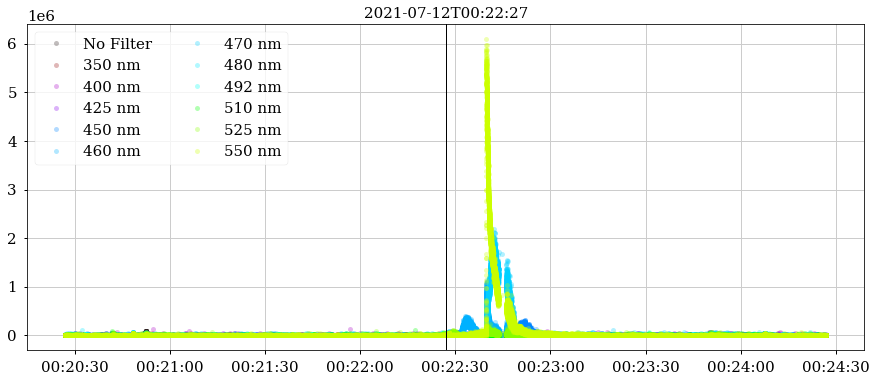

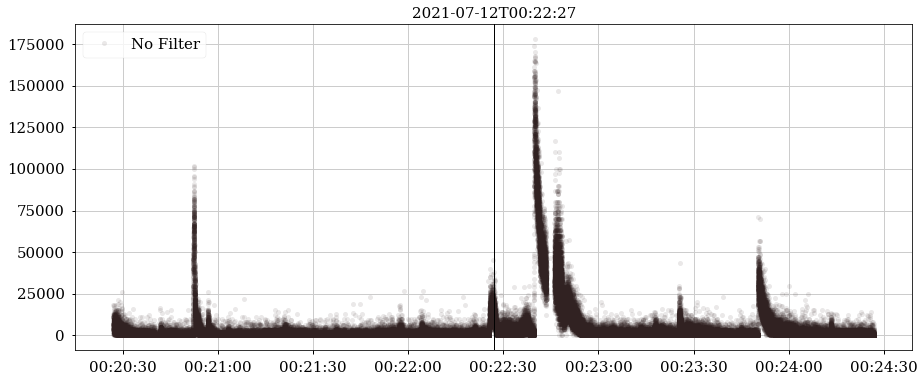

In [20]:
for pmtspec, timestamp in zip(pmt_specs, selected_timestamps):

    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = (
        np.asarray(
            np.round(pmtspec.trb_rates.rate_time_middle * 1e6), dtype="timedelta64[us]"
        )
        + pmtspec.trb_rates.time[0]
    )
    ### select +-2min around biolumi events
    timemask = times_ns >= timestamp - np.timedelta64(
        2, "m"
    )  # - np.timedelta64(30, "s")
    timemask &= times_ns <= timestamp + np.timedelta64(
        2, "m"
    )  # + np.timedelta64(30, "s")
    masked_times_ns = times_ns[timemask]

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.3,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array[
        pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
    ]:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.1,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")


## zoom ins

In [10]:
import colorsys
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.colors as mc


/tmp/ipykernel_54513/4257040791.py:2: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [11]:
def change_color_ld(color, amount=0.2):
    """slightly change the color lightness/darkness"""
    if not colorsys:
        print("Cannot change color.")
        return color
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c_new = np.clip(c[1] + amount, 0, 1)
    return colorsys.hls_to_rgb(c[0], c_new, c[2])


In [12]:
filter_N = 100


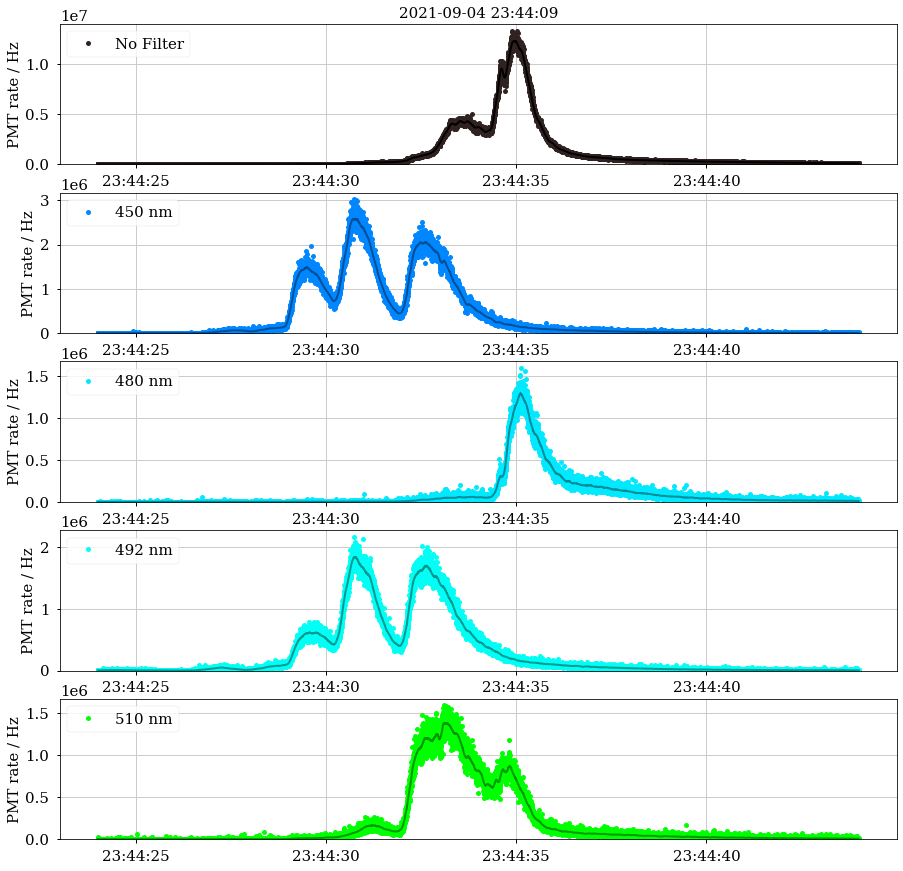

In [14]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = (
        np.asarray(
            np.round(pmtspec.trb_rates.rate_time_middle * 1e6), dtype="timedelta64[us]"
        )
        + pmtspec.trb_rates.time[0]
    )
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(15, "s")
timemask &= times_ns <= timestamp + np.timedelta64(35, "s")
masked_times_ns = times_ns[timemask]

wavelengths = [0, 450, 480, 492, 510]


f, axes = plt.subplots(nrows=len(wavelengths), figsize=(15, 15))
axes[0].set_title(str(timestamp).replace("T", " "))
mask =  pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
for wl in wavelengths[1:]:
    mask |=  pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == wl
for ii, ch in enumerate(pmtspec.pmt_meta_data.channel_meta_array[mask]):
    ax = axes[ii]
    _ = ax.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=1,
        ms=5,
    )
    ax.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), -0.2),
        lw=2,
        alpha=1,
    )
    ax.legend(loc=2, ncol=2)
    ax.set_ylabel("PMT rate / Hz")
    ylims = ax.get_ylim()
    ax.set_ylim(0, ylims[1])
f.savefig(f"../no_git/plot_dump/zoom_in_rate_timeseries_demo.png")

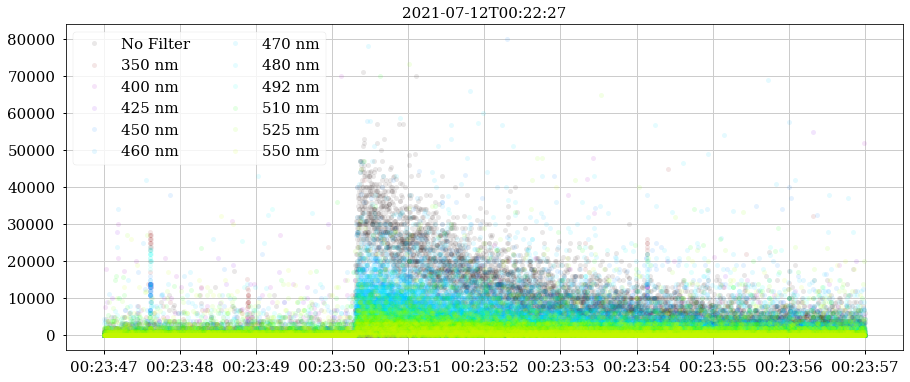

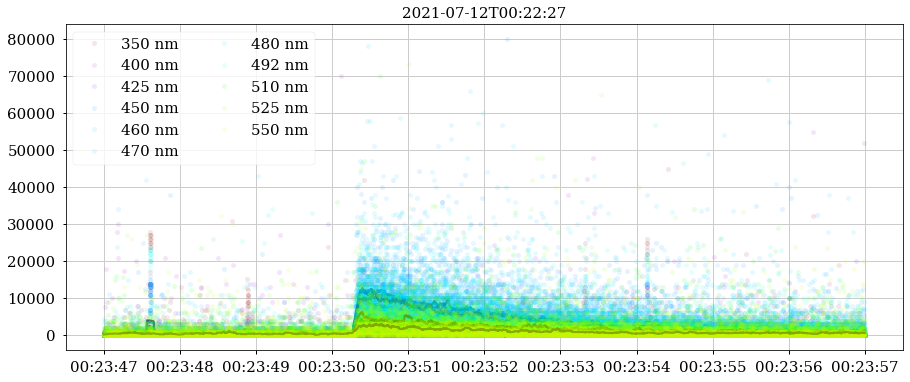

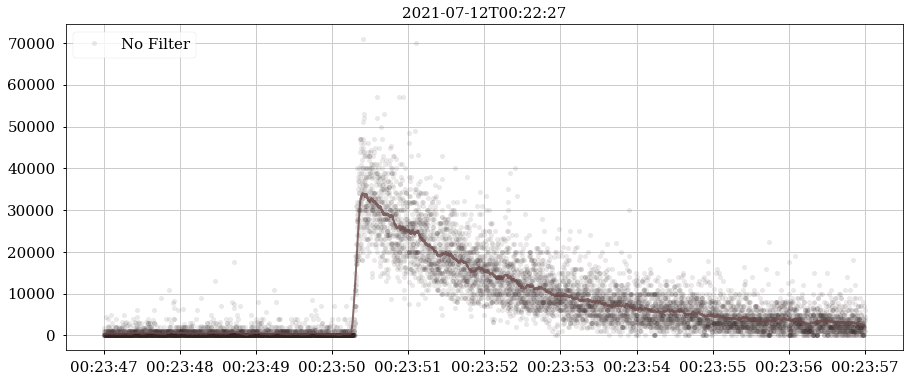

In [30]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = (
        np.asarray(
            np.round(pmtspec.trb_rates.rate_time_middle * 1e6), dtype="timedelta64[us]"
        )
        + pmtspec.trb_rates.time[0]
    )
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(80, "s")
timemask &= times_ns <= timestamp + np.timedelta64(90, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 6))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=2, ncol=2)
plt.savefig(f"../no_git/plot_dump/{timestamp}zoom_in_rate_timeseries_allfilter.png", bbox_inches="tight")

plt.figure(figsize=(15, 6))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), -0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)
plt.savefig(f"../no_git/plot_dump/{timestamp}zoom_in_rate_timeseries_colorfilter.png", bbox_inches="tight")

plt.figure(figsize=(15, 6))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)
plt.savefig(f"../no_git/plot_dump/{timestamp}zoom_in_rate_timeseries_nofilter.png", bbox_inches="tight")


# Find peaks and quantify

In [ ]:
from scipy.signal import find_peaks

filter_N = 100


In [ ]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
timemask = times_ns >= timestamp + np.timedelta64(0, "s")
timemask &= times_ns <= timestamp + np.timedelta64(90, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 6))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    smoothed_rate = uniform_filter1d(
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
    )
    plt.plot(
        masked_times_ns,
        smoothed_rate,
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
    peaks, prop = find_peaks(
        smoothed_rate,
        height=1e4,
        width=filter_N,
        distance=filter_N,
        rel_height=0.3
        # prominence=8E3
    )
    plt.plot(
        masked_times_ns[peaks], smoothed_rate[peaks], marker="o", lw=0, color="tab:blue"
    )
plt.legend(loc=2, ncol=2)
plt.semilogy()
plt.ylabel("Rate (Hz) per bin")
plt.xlabel("Time")

In [ ]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(30, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


In [ ]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(50, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


In [ ]:
pmtspec, timestamp = pmt_specs[2], selected_timestamps[2]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.5,
        ms=5,
    )
plt.legend(loc=1, ncol=2)
